# 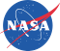 Advanced FIRMS API Training 🔥


This notebook is designed for ARSET advanced FIRMS training on using NASA's FIRMS (Fire Information for Resource Management System) APIs in Python.


We will cover:
- FIRMS API setup & authentication
- Using the **Area API** (focus of this training)
- Bounding Box queries (a special case of the Area API)
- Ingesting and cleaning FIRMS active fire data
- Visualizing and analyzing results


Finally, there is a **Knowledge Check / Homework Section** where you will modify queries and visualizations to test your understanding.


**Note:** The *Country API* is currently disabled. The **Area API** is the recommended replacement.

----

## FIRMS APIs Overview


1. **Area API** - retrieve active fire data for a given named area of interest (AOI).
2. **Area API with Bounding Box** - retrieve active fire data within a specified bounding box (lat/lon rectangle). This is essentially the Area API with bounding box parameters.
3. Subset by Shapefile - not a direct API, but you can download FIRMS data in a shapefile format from our downloads page [here](https://firms.modaps.eosdis.nasa.gov/active_fire/).


We will mainly use the **Area API** due to the outage of the country API. <br>
**Area API Link:** https://firms.modaps.eosdis.nasa.gov/api/area/
  - You can build a URL in the interface if you prefer that.

### Notes:
- [FIRMS FAQs ](https://www.earthdata.nasa.gov/data/tools/firms/faq)
  - These are helpful if you have any questions about datasets, access, or fire dections in general!
- Sources...
  - FAQ: [What are the key differences between URT/RT/NRT and Standard quality fire data?](https://www.earthdata.nasa.gov/data/tools/firms/faq#heading-accordion-124369-3)
  - FAQ: [How are URT active fire detection data integrated and used with NRT active fire detection data in FIRMS?](https://www.earthdata.nasa.gov/data/tools/firms/faq#heading-accordion-124500-5)
  - FAQ: [How do I identify the NRT, RT, and URT data?](https://www.earthdata.nasa.gov/data/tools/firms/faq#heading-accordion-124500-6)
  - FAQ: [Are URT data provided for all FIRMS products?](https://www.earthdata.nasa.gov/data/tools/firms/faq#heading-accordion-124500-7)
  - What are the sources available for the **Area API**?
    - Description of the below list ...
      - Dataset description/information: `Value_for_the_API` ...
    - Landsat NRT **[US/Canada Only]**: `LANDSAT_NRT`
    - MODIS URT+NRT: `MODIS_NRT`
    - MODIS **S**tandard **P**rocessing (SP): `MODIS_SP`
    - VIIRS NOAA-20 URT+NRT: `VIIRS_NOAA20_NRT`
    - VIIRS NOAA-20 SP: `VIIRS_NOAA20_SP`
    - VIIRS NOAA-21 URT+NRT: `VIIRS_NOAA21_NRT`
    - VIIRS S-NPP URT+NRT: `VIIRS_SNPP_NRT`
    - VIIRS S-NPP SP: `VIIRS_SNPP_SP`
- Other learning
  - See our other FIRMS Python Notebooks in the [FIRMS Fire Data Academy](https://firms.modaps.eosdis.nasa.gov/academy/)
  - See our other [FIRMS tutorials here](https://firms.modaps.eosdis.nasa.gov/tutorials/)

---

## Setup & Authentication

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

# TODO: ************************************************** Your FIRMS API key (replace with your own key) **************************************************
API_KEY = ""

BASE_URL = "https://firms.modaps.eosdis.nasa.gov/api"

print("Setup complete. API key loaded.")

---

## Area API Example

### World Example 🌎

Function to call the API...

In [ ]:
def get_area_data(area, dateString, source="VIIRS_SNPP_NRT", day_range=1):
  """
  Query FIRMS Area API.

  Parameters:
  - area: str, predefined AOI (e.g., "World" or "south")
  - source: str, dataset (VIIRS_SNPP_NRT, VIIRS_NOAA20_NRT, MODIS_NRT, etc.)
  - day_range: int, number of days back (1, 7, etc.)
  """
  url = f"{BASE_URL}/area/csv/{API_KEY}/{source}/{area}/{day_range}/{dateString}"
  print("API URL Used here: " + url)
  df = pd.read_csv(url)
  return df

Calling the function, with details passed into the API call... <br>


In [ ]:
# Example query: World fires from the past 24h
df_area = get_area_data("world", '2025-08-20', source='VIIRS_NOAA20_NRT', day_range=1)
print(df_area.head())

Printing the results to see if the API call worked

### Bounding Box Example 🔲

Function to call the API again...

In [ ]:
def get_bbox_data(bbox, dateString, source="VIIRS_SNPP_NRT", day_range=1):
  """
  Query FIRMS Area API with a bounding box.

  Parameters:
  - bbox: tuple, bounding box (minLon, minLat, maxLon, maxLat) of AOI
  - source: str, dataset (VIIRS_SNPP_NRT, VIIRS_NOAA20_NRT, MODIS_NRT, etc.)
  - day_range: int, number of days back (1, 7, etc.)
  """
  bbox_str = ",".join(map(str, bbox))
  url = f"{BASE_URL}/area/csv/{API_KEY}/{source}/{bbox_str}/{day_range}/{dateString}"
  print("API URL Used here: " + url)
  df = pd.read_csv(url)
  return df

Calling the function with a bound box, and other details passed into the API call

In [ ]:
# Example query: Fires in bounding box around Amazon Basin
bbox = (-75, -15, -50, 5)
df_bbox = get_bbox_data(bbox, '2025-08-26', day_range=1)
print(df_bbox.head())

Printing the results to make sure the API call worked


### Notes 🗒️

- The available sources are below
  - `LANDSAT_NRT` [US/Canada only] (LANDSAT Near Real-Time, Real-Time and Ultra Real-Time *)
  - `MODIS_NRT` (MODIS Near Real-Time, Real-Time and Ultra Real-Time *)
  - `MODIS_SP` (MODIS Standard Processing)
  - `VIIRS_NOAA20_NRT` (VIIRS NOAA-20 Near Real-Time, Real-Time and Ultra Real-Time *)
  - `VIIRS_NOAA20_SP` (VIIRS NOAA-20 Standard Processing)
  - `VIIRS_NOAA21_NRT` (VIIRS NOAA-21 Near Real-Time, Real-Time and Ultra Real-Time *)
  - `VIIRS_SNPP_NRT` (VIIRS Suomi-NPP Near Real-Time, Real-Time and Ultra Real-Time *)
  - `VIIRS_SNPP_SP` (VIIRS Suomi-NPP Standard Processing)

- The area 'world' requests a lot of data, requesting multiple days for a full world product will take up to 30 seconds to load

---

## 🔢 Data Ingestion

In [ ]:
# Convert to GeoDataFrame
def to_geodf(df):
  """
  Convert a FIRMS DataFrame with latitude/longitude into a GeoDataFrame.


  Why use a GeoDataFrame?
  - A GeoDataFrame (from GeoPandas) adds spatial context to tabular data.
  - It allows us to perform geospatial operations (clipping, buffering, joining with shapefiles).
  - Many visualization tools (Folium, GeoPandas, etc.) and analyses (spatial joins, projections) require geometry objects.
  - In this case, fire detections are inherently geographic (lat/lon points), so using a GeoDataFrame enables meaningful spatial analysis and mapping.
  """
  geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
  gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
  return gdf

In [ ]:
gdf_area = to_geodf(df_area)
print(gdf_area.head())

### Exercise Suggestion

👉 Exercise: Filter the dataset to only include hotspots with `confidence` > 80. How many remain?

---

## 📍Visualization

In [ ]:
# Static plot
fig, ax = plt.subplots(figsize=(6,6))
gdf_area.plot(ax=ax, color="red", markersize=5)
plt.title("Active Fires - World (8/20/25 + 2 days)")
plt.show()

In [ ]:
# --- Interactive Folium Map (Global Zoom + Smaller Output + Colored by Confidence) ---
m = folium.Map(location=[0, 0], zoom_start=2, width="60%", height="60%")
for _, row in gdf_area.iterrows():
  try:
    confidence_val = int(row.confidence) if row.confidence not in ['n', 'N', 'NA', 'nan', ''] else 0
    color = "green" if confidence_val >= 80 else "orange" if confidence_val >= 50 else "red"
  except (ValueError, TypeError):
    confidence_val = 0
    color = "gray"  # Use a different color for unknown confidence

  folium.CircleMarker(
    location=[row.latitude, row.longitude],
    radius=3,
    color=color,
    fill=True,
    fill_opacity=0.6,
    popup=f"Confidence: {row.confidence}"
  ).add_to(m)
m

---

## 📊 Analysis & Insights

In [ ]:
# Count fires by day
df_area['acq_date'] = pd.to_datetime(df_area['acq_date'])
daily_counts = df_area.groupby('acq_date').size()

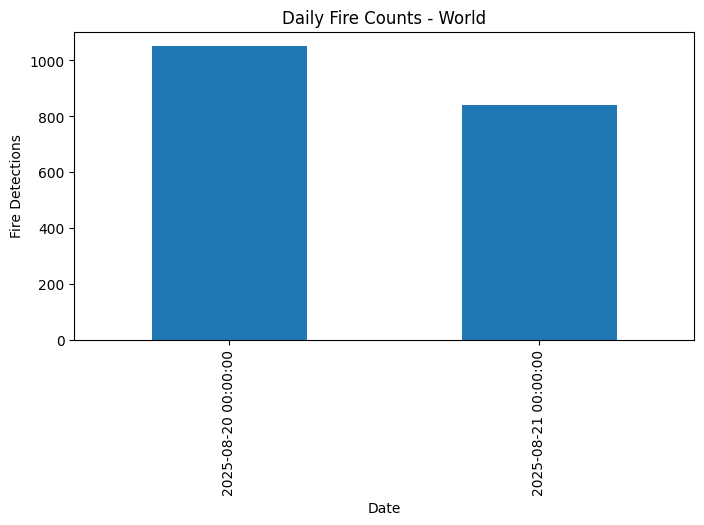

In [ ]:
plt.figure(figsize=(8,4))
daily_counts.plot(kind='bar')
plt.title("Daily Fire Counts - World")
plt.xlabel("Date")
plt.ylabel("Fire Detections")
plt.show()

---

## ✅ Conclusion

In this notebook, we:
- Set up authentication with the FIRMS API
- Retrieved data using the **Area API** and bounding box queries
- Ingested data into pandas/GeoPandas
- Visualized fire detections with static and interactive maps
- Analyzed temporal patterns

Next steps:
- Explore archive downloads for historical trends
- Overlay fire detections with land cover or population datasets
- Develop automated monitoring pipelines

🌐 More info: [FIRMS API Documentation](https://firms.modaps.eosdis.nasa.gov/api/)

---



## 📝 Homework

These questions are designed to test your ability to use the FIRMS API and interpret fire data.
Follow the prompts, run the provided code cells, and answer the multiple-choice questions.

### Q1: Bounding Box Exploration
We will examine fire activity for the a bounding box in the Mid-Atlantic Region in the US.
- Bounding Box: `(-77.871094, 38.212288, -74.794922, 39.715638)`
- Time: **4** days starting on `2025-05-14`
- Dataset: MODIS Standard Product (`MODIS_SP`)


Using the below code box, use the provided information in the homework to complete the questions...

Note: *You will **at least** need to run (hit play) the Setup & Authentication cell, and all of the cells with functions in them (hint: the code cells start with `def ...` to define a function)*

In [ ]:
# Edit these four variables below ...
boundingBox = ()
dateString = ''
satelliteDataType = ''
numberOfDays =
# ************************************

df_hw = get_bbox_data(boundingBox, dateString, source=satelliteDataType, day_range=numberOfDays)
gdf_hw = to_geodf(df_hw)

m_hw = folium.Map(location=[39, -76], zoom_start=7, width="60%", height="60%")
for _, row in gdf_hw.iterrows():
  folium.CircleMarker(
    location=[row.latitude, row.longitude],
    radius=3,
    color="blue",
    fill=True,
    fill_opacity=0.6,
    popup=f"Confidence: {row.confidence}"
  ).add_to(m_hw)
m_hw

### Q2: Palisades Fire (California Bounding Box)
We will examine fire activity for the Palisades Fire near Los Angeles.
- Bounding Box: `(-121.662598, 32.546813, -115.224609, 35.835628)`
- Time: **10** days starting on `2025-01-05`
- Dataset: `MODIS_SP` (standard product)


Run the following code to generate daily fire counts:
<br>
Note: *You will **at least** need to run (hit play) the Setup & Authentication cell, and all of the cells with functions in them (hint: the code cells start with `def ...` to define a function)*

In [ ]:
# Edit these four variables below ...
bbox_la = ()
dateString = ''
satelliteDataType = ''
numberOfDays = 
# ************************************

df_palisades = get_bbox_data(bbox_la, dateString, source=satelliteDataType, day_range=numberOfDays)
df_palisades["acq_date"] = pd.to_datetime(df_palisades["acq_date"])
daily_counts = df_palisades.groupby("acq_date").size()


plt.figure(figsize=(8,4))
daily_counts.plot(kind="bar")
plt.title("Daily Fire Counts - Palisades Fire (Jan 2025)")
plt.xlabel("Date")
plt.ylabel("Fire Detections")
plt.show()